In [1]:
!pip install py7zr
import keras
import numpy as np
import pandas as pd
import os
from PIL import Image
from shutil import rmtree

from re import findall
import py7zr
from pathlib import Path
from tqdm import tqdm

     |████████████████████████████████| 76 kB 2.5 MB/s 
     |████████████████████████████████| 57 kB 4.0 MB/s 
     |████████████████████████████████| 2.4 MB 28.6 MB/s 
     |████████████████████████████████| 131 kB 45.2 MB/s 
     |████████████████████████████████| 357 kB 47.2 MB/s 
     |████████████████████████████████| 2.0 MB 35.4 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 


In [3]:


make_dir = Path('/content/egohands')
path_to_source_folder = Path('/content/drive/MyDrive/hand_rcnn/egohands_kitti_formatted.7z')
if make_dir.exists(): rmtree(make_dir)
make_dir.mkdir()

if findall('.7z', str(path_to_source_folder)):
    with py7zr.SevenZipFile(path_to_source_folder, mode='r') as z:
        z.extractall('/content/egohands')
    path_to_source_folder = Path('/content/egohands/egohands_kitti_formatted')
elif findall('.zip', str(path_to_source_folder)):
    !unzip $path_to_source_folder -d /content/ASLdataset
    path_to_source_folder = Path('/content/egohands/egohands_kitti_formatted')
else:
    path_to_source_folder = Path(path_to_source_folder)

In [4]:
imgs = list(os.listdir(os.path.join(path_to_source_folder,"images")))
boxes = list(os.listdir(os.path.join(path_to_source_folder,"labels")))

In [7]:
def splitlist(tokens):
    n = int(len(tokens)/4)
    return [tokens[i:i+4] for i in range(0, len(tokens), 4)]
def txtToArray(path):
    f = open(path)
    tokens=f.read().split()
    # tokens = [i for i in tokens if i != '0' and i!='hand']
    j=0
    ftoken = []
    while j< len(tokens):
        if tokens[j]!='0' and tokens[j]!='hand':
            ftoken.extend([tokens[j],tokens[j+1],tokens[j+2],tokens[j+3]])
            j=j+4
        else:
            j+=1
    tokens = splitlist(ftoken)
    # for i in range(0,len(tokens)): tokens[i]=tokens[i].split(',')
    A=np.array(tokens, dtype=np.int)
    return(A)
def __getitem__(idx):
    pic_count=idx
    i = 1+int(idx/100)
    j = 1+(idx%100)
    # imgStr = "Image"+str(i)+"_"+str(j)+".jpg"
    # boxStr = "Box"+str(i)+"_"+str(j)+".txt"
    # img_path = os.path.join('', "DATA_IMAGES",imgStr)
    # box_path = os.path.join('',"DATA_BOXES",boxStr)
    img_path = str(all_img_path[pic_count])
    box_path = str(str(img_path[:43])+'labels'+str(img_path[49:-3])+'txt')
    i+=1
    box_array = txtToArray(box_path)
    im = Image.open(img_path).convert("RGB")
    boxes = []
    for k in range(len(box_array)):  #get the bounding boxes for all hands in image with xmin,ymin,xmax,ymax coords
        if box_array[k,2] != 0:
            xmin = box_array[k,0]
            ymin = box_array[k,1]
            xmax = xmin+box_array[k,2]
            ymax = ymin + box_array[k,3]
            boxes.append([xmin,ymin,xmax,ymax])
    if len(boxes)==0:
        idx = (idx+1)%4800
        return __getitem__(idx)
    big_box = [1199,1199,0,0]         #big box is the Region of Interest, essentially a cropping of the image
    for k in range(len(boxes)):
        if boxes[k][0] < big_box[0]:
            big_box[0] = boxes[k][0]
        if boxes[k][1] < big_box[1]:
            big_box[1] = boxes[k][1]
        if boxes[k][2] > big_box[2]:
            big_box[2] = boxes[k][2]
        if boxes[k][3] > big_box[3]:
            big_box[3] = boxes[k][3]
    im_array = np.asarray(im)
    ROI = im_array[big_box[1]:big_box[3],big_box[0]:big_box[2],:]          #a crop of the image
    ROI_Image = Image.fromarray(ROI, 'RGB')

    # ROI_Image.save('/content/images/'+str(img_path[50:-4])+'.png')
    ROI_Resize = ROI_Image.resize((32,32))
    ROI_npArr = np.asarray(ROI_Resize)
    # ROI_npArr.save('gfg_dummy_pic_2.png')
    # data = im.fromarray(ROI_npArr)
    # data.save('gfg_dummy_pic_3.png')
    
    #Image_Resize = np.asarray(im.resize((64,64)))
    label = 0
    if i>0 and i<13:
        label = 0    #cards
    if i>12 and i<25:
        label = 1    #chess
    if i>24 and i<37:
        label = 2    #jenga
    if i>36 and i<49:
        label = 3   #puzzle
    return ROI_npArr, label

In [8]:
X_train = []
Y_train = []
X_test = []
Y_test = []
all_img_path = list((Path('/content/egohands/egohands_kitti_formatted/images')).glob("*"))
print(len(all_img_path))
pbar = tqdm(total=len(all_img_path), bar_format ='{l_bar}{bar}|  {n_fmt}/{total_fmt}  [ Elapsed Time : {elapsed} | ETA : {remaining} ]', leave=True, position=0)
for idx in range(len(all_img_path)):
    i = 1+int(idx/100)  #video 
    j = 1+(idx%100)
    pbar.update(1)
    ROI, activity = __getitem__(idx)
    #lets take first 11 videos as training for each activity
    toTrain = (i-1)%12
    if (toTrain >= 0) and (toTrain <= 10):
        X_train.append(ROI)
        Y_train.append(activity)
    else:
        X_test.append(ROI)
        Y_test.append(activity)

4800


  0%|          |  0/4800  [ Elapsed Time : 00:00 | ETA : ? ]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|█████████▉|  4798/4800  [ Elapsed Time : 02:40 | ETA : 00:00 ]

In [ ]:
path = '/content/egohands/egohands_kitti_formatted/images/JENGA_LIVINGROOM_H_B_frame_0333.jpg'
print(path[50:-4])

In [9]:
X_tr = np.array(X_train)
Y_tr = np.array(Y_train)
X_te = np.array(X_test)
Y_te = np.array(Y_test)

In [10]:
from tensorflow.keras.utils import to_categorical
Y_tr = to_categorical(Y_tr)
Y_te = to_categorical(Y_te)

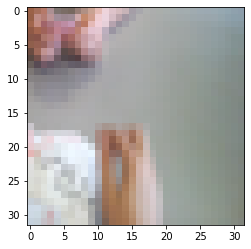

In [11]:
import matplotlib.pyplot as plt
plt.imshow(X_tr[1])
plt.show()

In [12]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout,Activation
model = Sequential()

In [13]:
model.add(Conv2D(128,kernel_size=3,activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(4 ,activation='softmax'))

In [14]:
import tensorflow as tf
sgd = tf.keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        73792     
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/hand_rcnn/model_new0.9390909075737') #load the last checkpoint file

In [16]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if int(epoch)%100 == 0:  # or save after some epoch, each k-th epoch etc.
            model.save(Path(str('/content/drive/MyDrive/hand_rcnn') + "/model_new_wtihdropout" + str(logs.get('accuracy'))))
            


In [17]:
saver = CustomSaver()
history = model.fit(X_tr,Y_tr,validation_data=(X_te,Y_te), callbacks=[saver], epochs=500,shuffle=True)

Epoch 1/500
 82/138 [================>.............] - ETA: 6s - loss: 3.6615 - accuracy: 0.2473

100%|██████████|  4800/4800  [ Elapsed Time : 02:52 | ETA : 00:00 ]

138/138 [==============================] - 19s 135ms/step - loss: 3.0691 - accuracy: 0.2466 - val_loss: 1.8684 - val_accuracy: 0.2575
Epoch 2/500
138/138 [==============================] - 17s 125ms/step - loss: 1.8792 - accuracy: 0.2527 - val_loss: 1.7058 - val_accuracy: 0.2300
Epoch 3/500
138/138 [==============================] - 17s 125ms/step - loss: 1.6610 - accuracy: 0.2582 - val_loss: 1.4262 - val_accuracy: 0.2600
Epoch 4/500
138/138 [==============================] - 17s 124ms/step - loss: 1.4112 - accuracy: 0.2557 - val_loss: 1.3929 - val_accuracy: 0.2400
Epoch 5/500
138/138 [==============================] - 17s 124ms/step - loss: 1.3929 - accuracy: 0.2582 - val_loss: 1.3901 - val_accuracy: 0.2425
Epoch 6/500
138/138 [==============================] - 17s 125ms/step - loss: 1.3864 - accuracy: 0.2586 - val_loss: 1.3892 - val_accuracy: 0.2375
Epoch 7/500
138/138 [==============================] - 17s 125ms/step - loss: 1.3855 - accuracy: 0.2543 - val_loss: 1.3897 - val_accurac

In [ ]:
saver = CustomSaver()
history = model.fit(X_tr,Y_tr,validation_data=(X_te,Y_te), callbacks=[saver], epochs=500,shuffle=True)


Epoch 1/500
138/138 [==============================] - 18s 125ms/step - loss: 3.0207 - accuracy: 0.2520 - val_loss: 1.9655 - val_accuracy: 0.3100
Epoch 2/500
138/138 [==============================] - 16s 117ms/step - loss: 1.9131 - accuracy: 0.2570 - val_loss: 1.7684 - val_accuracy: 0.2625
Epoch 3/500
138/138 [==============================] - 16s 117ms/step - loss: 1.6846 - accuracy: 0.2709 - val_loss: 1.6578 - val_accuracy: 0.2750
Epoch 4/500
138/138 [==============================] - 16s 117ms/step - loss: 1.5600 - accuracy: 0.2770 - val_loss: 1.5038 - val_accuracy: 0.2775
Epoch 5/500
138/138 [==============================] - 16s 117ms/step - loss: 1.4728 - accuracy: 0.2732 - val_loss: 1.4528 - val_accuracy: 0.2750
Epoch 6/500
138/138 [==============================] - 16s 117ms/step - loss: 1.4232 - accuracy: 0.2745 - val_loss: 1.3809 - val_accuracy: 0.2650
Epoch 7/500
138/138 [==============================] - 16s 117ms/step - loss: 1.3949 - accuracy: 0.2641 - val_loss: 1.3796 -

In [ ]:
ACCURACY_THRESHOLD = 0.95
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if int(epoch)%100 == 0:  # or save after some epoch, each k-th epoch etc.
            model.save(Path(str('/content/drive/MyDrive/hand_rcnn') + "/model_new" + str(logs.get('accuracy'))))        
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
                print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
                self.model.stop_training = True

In [ ]:
saver = CustomSaver()
history = model.fit(X_tr,Y_tr,validation_data=(X_te,Y_te), callbacks=[saver], epochs=1000,shuffle=True)


Epoch 1/1000
138/138 [==============================] - 26s 189ms/step - loss: 0.7964 - accuracy: 0.6866 - val_loss: 1.8624 - val_accuracy: 0.2925
Epoch 2/1000
138/138 [==============================] - 16s 116ms/step - loss: 0.7942 - accuracy: 0.6914 - val_loss: 1.8464 - val_accuracy: 0.2800
Epoch 3/1000
138/138 [==============================] - 16s 115ms/step - loss: 0.7963 - accuracy: 0.6882 - val_loss: 1.8710 - val_accuracy: 0.2775
Epoch 4/1000
138/138 [==============================] - 16s 115ms/step - loss: 0.7903 - accuracy: 0.6907 - val_loss: 1.8662 - val_accuracy: 0.2875
Epoch 5/1000
138/138 [==============================] - 16s 114ms/step - loss: 0.7913 - accuracy: 0.6868 - val_loss: 1.8986 - val_accuracy: 0.2775
Epoch 6/1000
138/138 [==============================] - 16s 116ms/step - loss: 0.7895 - accuracy: 0.6877 - val_loss: 1.8600 - val_accuracy: 0.2825
Epoch 7/1000
138/138 [==============================] - 16s 115ms/step - loss: 0.7897 - accuracy: 0.6923 - val_loss: 1

In [ ]:
import pickle
with open(str('/content/drive/MyDrive/hand_rcnn/history.pkle'),'wb') as xyz:
    pickle.dump(history,xyz)
# filehandler = open("history","wb")
# pickle.dump(history,filehandler)

In [ ]:
print('Saving model')
model.save(Path(str('/content/drive/MyDrive/hand_rcnn/model3')))

Saving model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/hand_rcnn/model3/assets


In [ ]:
print(X_te[1].shape)

(32, 32, 3)


In [ ]:
preds = model.predict(X_te)
counter = 0
for i in range(len(preds)):
    preds[i] = np.round(preds[i],0)
    if np.array_equal(Y_te[i],preds[i]):
        counter = counter +1

In [ ]:
video_scores = [0,0,0,0]
for i in range(len(preds)):
    video = int(i/100)
    if np.array_equal(Y_te[i],preds[i]):
        video_scores[video] = video_scores[video]+1
print(video_scores)    #this gives amount of frames correctly classified in each of the 4 videos (cards,chess,jenga,puzzle)

[20, 28, 27, 27]


In [ ]:
def Preprocessimage(new_image_path):
    im = Image.open(new_image_path).convert("RGB")
    im_array = np.asarray(im)
    ROI_Image = Image.fromarray(im_array, 'RGB')
    ROI_Resize = ROI_Image.resize((32,32))
    ROI_npArr = np.asarray(ROI_Resize)
    return ROI_npArr

In [ ]:
newimage = '/content/drive/MyDrive/hand.webp'

preproimage = Preprocessimage(newimage)
print(preproimage.shape)
preds = model.predict(preproimage)


print(preds)

(32, 32, 3)


ValueError: ignored

In [ ]:
!zip -r /content/drive/MyDrive/handrcnnimages.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/PUZZLE_LIVINGROOM_B_T_frame_0702.png (deflated 0%)
  adding: content/images/PUZZLE_OFFICE_H_B_frame_1527.png (deflated 0%)
  adding: content/images/CARDS_COURTYARD_T_B_frame_1672.png (deflated 0%)
  adding: content/images/CARDS_LIVINGROOM_S_H_frame_1423.png (deflated 0%)
  adding: content/images/CHESS_COURTYARD_H_S_frame_0302.png (deflated 0%)
  adding: content/images/CARDS_OFFICE_T_H_frame_0487.png (deflated 0%)
  adding: content/images/JENGA_OFFICE_B_S_frame_0844.png (deflated 0%)
  adding: content/images/CHESS_OFFICE_T_H_frame_1946.png (deflated 0%)
  adding: content/images/CHESS_OFFICE_H_T_frame_1847.png (deflated 0%)
  adding: content/images/JENGA_LIVINGROOM_H_B_frame_1668.png (deflated 0%)
  adding: content/images/JENGA_COURTYARD_H_B_frame_0228.png (deflated 0%)
  adding: content/images/JENGA_COURTYARD_B_H_frame_1068.png (deflated 0%)
  adding: content/images/CARDS_COURTYARD_H_S_frame_2134.png (deflated 0%)
  adding: 

In [ ]:
newimage = '/content/drive/MyDrive/hand.webp'